# Logistic regression with PyMC3

As discussed in chapter 6, logistic regression estimates a linear relationship between a set of features and a binary outcome, mediated by a sigmoid function to ensure the model produces probabilities. The frequentist approach resulted in point estimates for the parameters that measure the influence of each feature on the probability that a data point belongs to the positive class, with confidence intervals based on assumptions about the parameter distribution. 

In contrast, Bayesian logistic regression estimates the posterior distribution over the parameters itself. The posterior allows for more robust estimates of what is called a Bayesian credible interval for each parameter with the benefit of more transparency about the model’s uncertainty.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats

import pandas_datareader.data as web

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

In [3]:
sns.set_style('whitegrid')

In [4]:
data_path = Path('data')
fig_path = Path('figures')
model_path = Path('models')
for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()

## The Data: Recessions & Leading Indicators

We will use a simple dataset that classifies 30,000 individuals by income using a threshold of \\$50K per year and contains information on age, sex, hours worked and years of education. Hence, we are modeling the probability that an individual earns more than $50K using these features.

### Download from FRED

In [5]:
indicators = ['JHDUSRGDPBR', 'T10Y3M', 'NFCI', 'NFCILEVERAGE', 'UMCSENT']
var_names = ['recession', 'yield_curve', 'financial_conditions', 'leverage', 'sentiment']

In [6]:
features = var_names[1:]
label = var_names[0]

In [7]:
var_display = ['Recession', 'Yield Curve', 'Financial Conditions', 'Leverage', 'Sentiment']
col_dict = dict(zip(var_names, var_display))

In [8]:
data = (web.DataReader(indicators, 'fred', 1980, 2020)
        .ffill()
        .resample('M')
        .last()
        .dropna())
data.columns = var_names

We standardize the features so all have mean 0 standard deviation of 1:

In [9]:
data.loc[:, features] = scale(data.loc[:, features])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 1982-01-31 to 2020-01-31
Freq: M
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             457 non-null    float64
 1   yield_curve           457 non-null    float64
 2   financial_conditions  457 non-null    float64
 3   leverage              457 non-null    float64
 4   sentiment             457 non-null    float64
dtypes: float64(5)
memory usage: 21.4 KB


### Quick exploration

In [11]:
mi = []
months = list(range(1, 25))
for month in months:
    df_ = data.copy()
    df_[label] = df_[label].shift(-month)
    df_ = df_.dropna()
    mi.append(mutual_info_classif(df_.loc[:, features], df_[label]))
mi = pd.DataFrame(mi, columns=features, index=months)

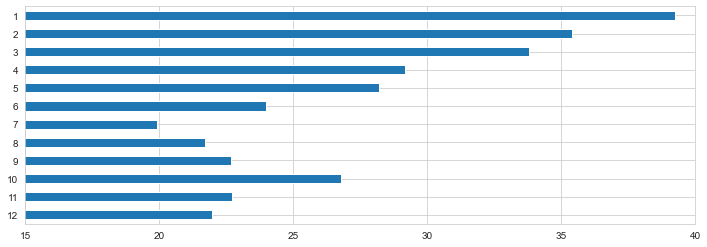

In [12]:
mi.sum(1).mul(100).iloc[:12].sort_index(ascending=False).plot.barh(figsize=(12, 4), xlim=(15, 40));

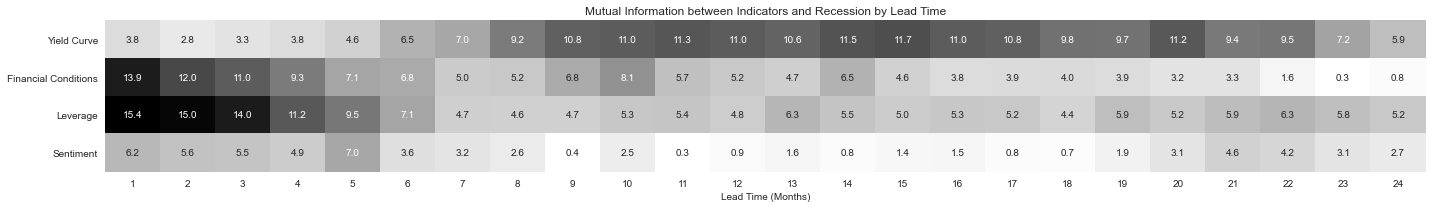

In [13]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(mi.rename(columns=col_dict).T*100, cmap='Greys', ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Mutual Information between Indicators and Recession by Lead Time')
fig.tight_layout()
fig.savefig('figures/heatmap');

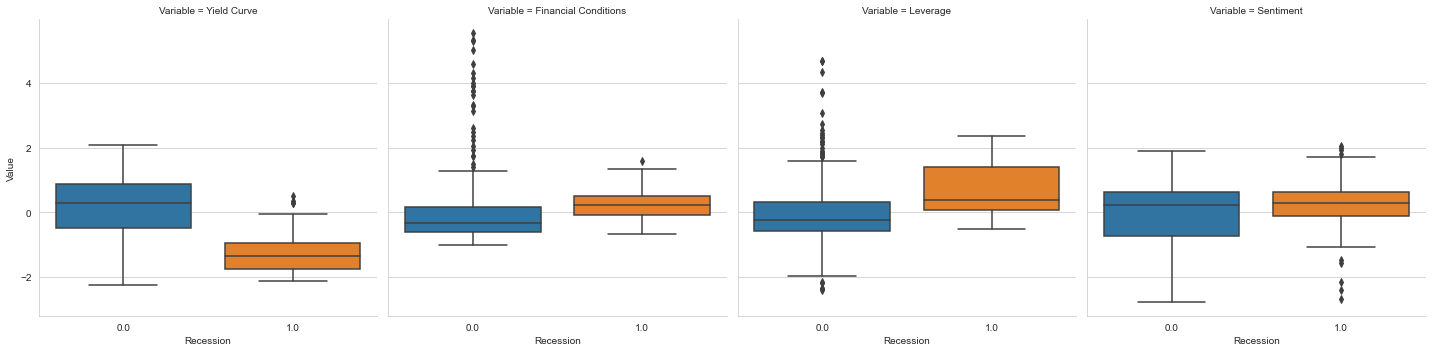

In [14]:
data[label] = data[label].shift(-12)
data = data.dropna()
data_ = pd.melt(data.rename(columns=col_dict), id_vars='Recession').rename(columns=str.capitalize)
g = sns.catplot(x='Recession', y='Value', col='Variable', data=data_, kind='box')
g.savefig('figures/catplot', dpi=300);

In [15]:
X = data.loc[:, features]
y = data[label]

In [16]:
y.value_counts()

0.0    397
1.0     48
Name: recession, dtype: int64

In [17]:
data.to_csv('data/recessions.csv')

### Load from Disk

In [18]:
data = pd.read_csv('data/recessions.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 1982-01-31 to 2019-01-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             445 non-null    float64
 1   yield_curve           445 non-null    float64
 2   financial_conditions  445 non-null    float64
 3   leverage              445 non-null    float64
 4   sentiment             445 non-null    float64
dtypes: float64(5)
memory usage: 20.9+ KB


### Models

In [19]:
simple_model = 'recession ~ yield_curve + leverage'
full_model =  simple_model + ' + financial_conditions + sentiment'

## MAP Inference

A probabilistic program consists of observed and unobserved random variables (RVs). As discussed, we define the observed RVs via likelihood distributions and unobserved RVs via prior distributions. PyMC3 includes numerous probability distributions for this purpose.

The PyMC3 library makes it very straightforward to perform approximate Bayesian inference for logistic regression. Logistic regression models the probability that individual i earns a high income based on k features as outlined in the below figure that uses plate notation:

### Manual Model Specification

We will use the context manager with to define a manual_logistic_model that we can refer to later as a probabilistic model:
- The random variables for the unobserved parameters for intercept and two features are expressed using uninformative priors that assume normal distributions with mean 0 and standard deviation of 100.
- The likelihood combines the parameters with the data according to the specification of the logistic regression
- The outcome is modeled as a Bernoulli RV with success probability given by the likelihood.

In [20]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + 
                             beta_1 * data.yield_curve +
                             beta_2 * data.leverage)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', 
                 p=likelihood, 
                 observed=data.recession)

In [21]:
manual_logistic_model.model

The command `pm.model_to_graphviz(manual_logistic_model)` produces the plate notation displayed below. 

It shows the unobserved parameters as light and the observed elements as dark circles. The rectangle indicates the number of repetitions of the observed model element implied by the data included in the model definition.

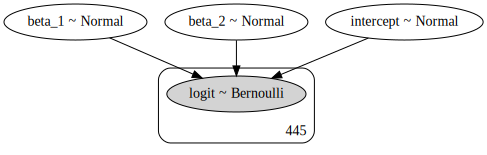

In [22]:
pm.model_to_graphviz(manual_logistic_model)

In [23]:
graph = pm.model_to_graphviz(manual_logistic_model)
graph.save('figures/log_reg.dot')

'figures/log_reg.dot'

### Run Inference

In [24]:
with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

logp = -94.419, ||grad|| = 0.02423: 100%|██████████| 14/14 [00:00<00:00, 3151.92it/s]  


In [25]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

In [26]:
print_map(manual_map_estimate)

intercept   -4.892612
beta_1      -3.032758
beta_2       1.533957
dtype: float64

### GLM Model

PyMC3 includes numerous common models so that we can usually leave the manual specification for custom applications. 

The following code defines the same logistic regression as a member of the Generalized Linear Models (GLM) family using the formula format inspired by the statistical language R and ported to python by the `patsy` library:

In [27]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            data,
                            family=pm.glm.families.Binomial())

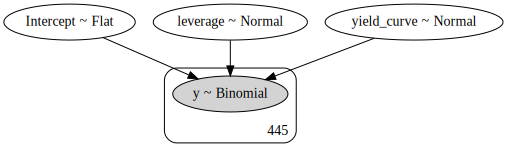

In [28]:
pm.model_to_graphviz(logistic_model)

### MAP Estimate

We obtain point MAP estimates for the three parameters using the just defined model’s .find_MAP() method:

In [29]:
with logistic_model:
    map_estimate = pm.find_MAP()

logp = -93.499, ||grad|| = 0.02424: 100%|██████████| 14/14 [00:00<00:00, 3390.51it/s]  


PyMC3 solves the optimization problem of finding the posterior point with the highest density using the quasi-Newton Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm but offers several alternatives provided by the scipy library. The result is virtually identically to the corresponding statsmodels estimate:

In [30]:
model = smf.logit(formula=simple_model, data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.174933
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              recession   No. Observations:                  445
Model:                          Logit   Df Residuals:                      442
Method:                           MLE   Df Model:                            2
Date:                Sun, 19 Apr 2020   Pseudo R-squ.:                  0.4885
Time:                        20:56:03   Log-Likelihood:                -77.845
converged:                       True   LL-Null:                       -152.20
Covariance Type:            nonrobust   LLR p-value:                 5.093e-33
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.8929      0.609     -8.041      0.000      -6.086      -3.700
yield_curve    -3.0330    

In [31]:
print_map(map_estimate)

Intercept     -4.892884
yield_curve   -3.032943
leverage       1.534055
dtype: float64

In [32]:
result.params

Intercept     -4.892907
yield_curve   -3.032966
leverage       1.534069
dtype: float64

## Markov Chain Monte Carlo

In [33]:
def plot_traces(traces, burnin=2000):
    summary = pm.summary(traces[burnin:])['mean'].to_dict()
    ax = pm.traceplot(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points',
                          rotation=90, va='bottom',
                          fontsize='large',
                          color='#AA0022')

### Define the Model

We will use the full model to illustrate Markov Chain Monte Carlo inference:

In [34]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

In [36]:
logistic_model.basic_RVs

[Intercept, yield_curve, leverage, financial_conditions, sentiment, y]

### Metropolis-Hastings
We will use the Metropolis-Hastings algorithm to sample from the posterior distribution.

Explore the hyperparameters of Metropolis-Hastings such as the proposal distribution variance to speed up the convergence. 
Use `plot_traces` function to visually inspect the convergence.

You may also use MAP-estimate to initialize the sampling scheme to speed things up. This will make the warmup (burnin) period shorter since you will start from a probable point.

In [37]:
with logistic_model:
    trace_mh = pm.sample(tune=1000,
                         draws=5000,
                         step=pm.Metropolis(),
                         cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:05<00:00, 4612.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


### Inspect Trace

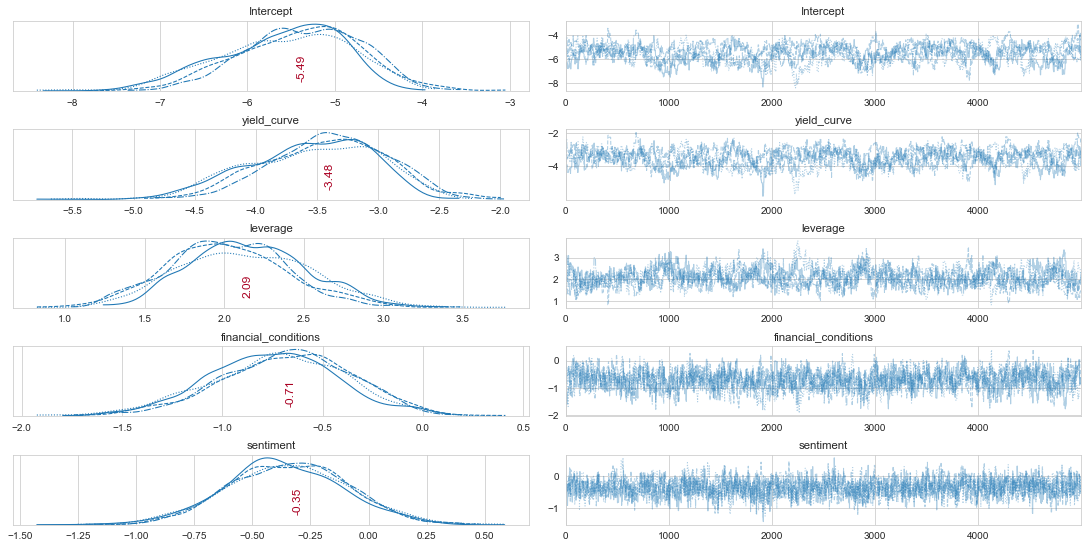

In [38]:
plot_traces(trace_mh, burnin=0)

In [39]:
pm.trace_to_dataframe(trace_mh).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             20000 non-null  float64
 1   yield_curve           20000 non-null  float64
 2   leverage              20000 non-null  float64
 3   financial_conditions  20000 non-null  float64
 4   sentiment             20000 non-null  float64
dtypes: float64(5)
memory usage: 781.4 KB


### Continue Training

In [40]:
with logistic_model:
    trace_mh = pm.sample(draws=100000,
                         step=pm.Metropolis(),
                         trace=trace_mh)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [01:29<00:00, 4511.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


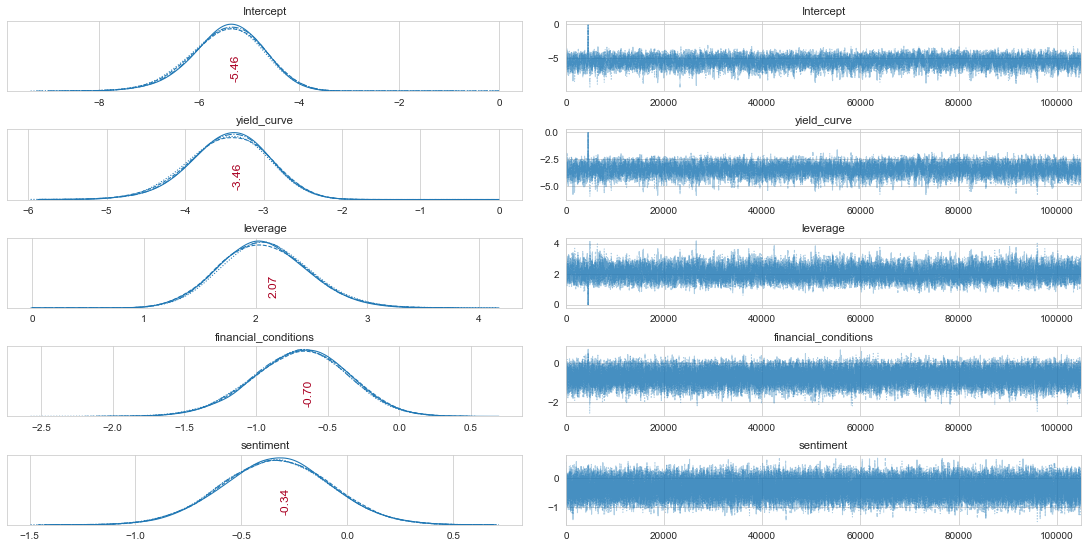

In [41]:
plot_traces(trace_mh, burnin=0)

In [42]:
with open(model_path / 'logistic_model_mh.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model, 'trace': trace_mh}, buff)

In [43]:
with open(model_path / 'logistic_model_mh.pkl', 'rb') as buff:
    pickled_data = pickle.load(buff)  

logistic_model, trace_mh = pickled_data['model'], pickled_data['trace']

In [44]:
pm.summary(trace_mh)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-5.460,0.701,-6.771,-4.163,0.012,0.009,3312.0,3298.0,3343.0,6113.0,1.0
yield_curve,-3.461,0.500,-4.411,-2.547,0.008,0.006,3462.0,3434.0,3496.0,6625.0,1.0
leverage,2.073,0.391,1.322,2.789,0.006,0.004,4204.0,4183.0,4238.0,8449.0,1.0
financial_conditions,-0.700,0.330,-1.324,-0.089,0.003,0.002,9181.0,9181.0,9240.0,19562.0,1.0
sentiment,-0.340,0.253,-0.816,0.134,0.002,0.001,16850.0,16850.0,16857.0,33206.0,1.0


### NUTS sampler
Using pm.sample without specifying a sampling method defaults to the No U-Turn Sampler, a form of Hamiltonian Monte Carlo that automatically tunes its parameters. It usually converges faster and gives less correlated samples compared to vanilla Metropolis-Hastings.

Note that variables measured on very different scales can slow down the sampling process. Hence, we first apply sklearn’s the scale() function to standardize the variables age, hours and educ.

#### Draw small number of samples

Once we have defined our model as above with the new formula, we are ready to perform inference to approximate the posterior distribution. MCMC sampling algorithms are available through the pm.sample() function. 

By default, PyMC3 automatically selects the most efficient sampler and initializes the sampling process for efficient convergence. For a continuous model, PyMC3 chooses the NUTS sampler discussed in the previous section. It also runs variational inference via ADVI to find good starting parameters for the sampler. One among several alternatives is to use the MAP estimate. 

To see convergence looks like, we first draw only 100 samples after tuning the sampler for 1,000 iterations that will be discarded. The sampling process can be parallelized for multiple chains using the cores argument (except when using GPU).

In [45]:
draws = 100
tune = 1000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws,
                           tune=tune,
                           init='adapt_diag',
                           chains=4,
                           cores=4,
                           random_seed=42)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 4400/4400 [00:02<00:00, 1844.37draws/s]


In [46]:
trace_df = pm.trace_to_dataframe(trace_NUTS).assign(
    chain=lambda x: x.index // draws)
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             400 non-null    float64
 1   yield_curve           400 non-null    float64
 2   leverage              400 non-null    float64
 3   financial_conditions  400 non-null    float64
 4   sentiment             400 non-null    float64
 5   chain                 400 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.9 KB


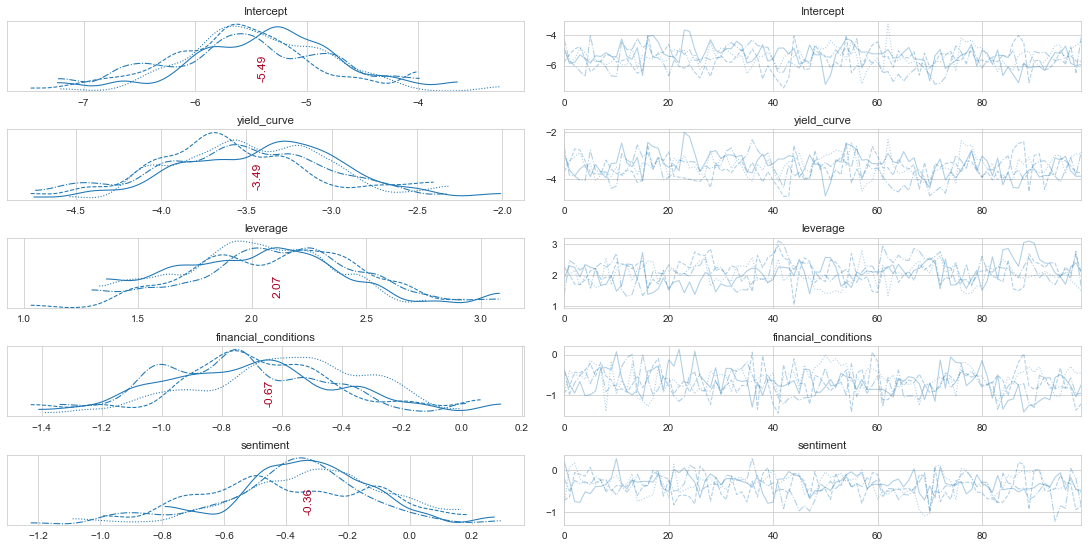

In [47]:
plot_traces(trace_NUTS, burnin=0)

#### Continue Training

The resulting trace contains the sampled values for each random variable. We can continue sampling by providing the trace of a prior run as input:

In [48]:
draws = 50000
chains = 4
with logistic_model:
    trace_NUTS = pm.sample(draws=draws, 
                           tune=tune,
                           init='adapt_diag',
                           trace=trace_NUTS,
                           chains=chains, 
                           cores=4,
                           random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 204000/204000 [01:28<00:00, 2317.50draws/s]


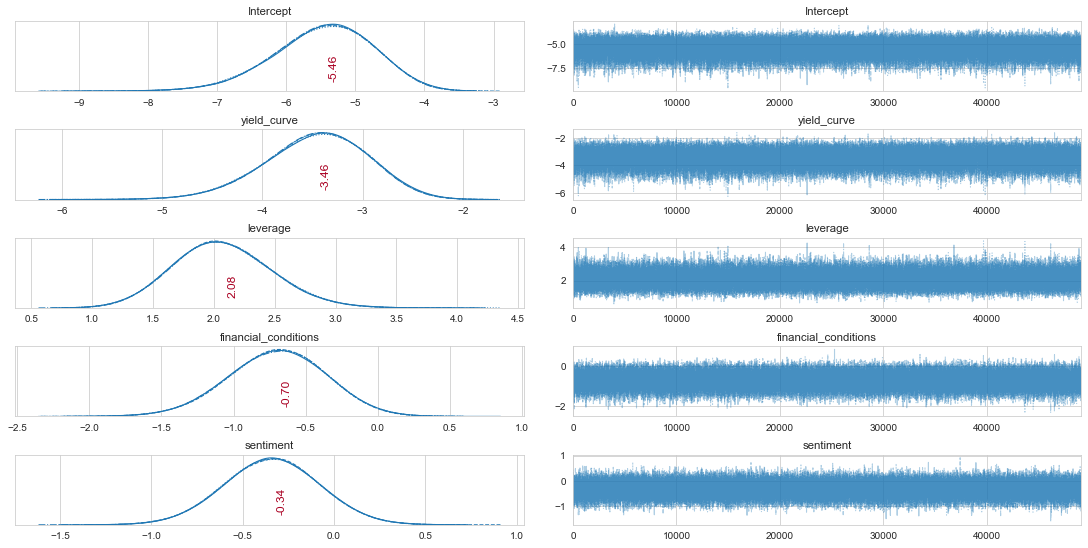

In [49]:
plot_traces(trace_NUTS, burnin=1000)

#### Persist Results

In [50]:
with open(model_path / 'logistic_model_nuts.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model,
                 'trace': trace_NUTS}, buff)

In [51]:
with open(model_path / 'logistic_model_nuts.pkl', 'rb') as buff:
    pickled_data = pickle.load(buff)  

logistic_model, trace_NUTS = pickled_data['model'], pickled_data['trace']

#### Combine Traces

In [52]:
df = pm.trace_to_dataframe(trace_NUTS).iloc[200:].reset_index(
    drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(samples=100),
                      df.assign(samples=len(df) + len(trace_df))])
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200600 entries, 0 to 200199
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Intercept             200600 non-null  float64
 1   yield_curve           200600 non-null  float64
 2   leverage              200600 non-null  float64
 3   financial_conditions  200600 non-null  float64
 4   sentiment             200600 non-null  float64
 5   chain                 200600 non-null  int64  
 6   samples               200600 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 12.2 MB


#### Visualize both traces

In [53]:
trace_df_long = pd.melt(trace_df, id_vars=['samples', 'chain'])
trace_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003000 entries, 0 to 1002999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   samples   1003000 non-null  int64  
 1   chain     1003000 non-null  int64  
 2   variable  1003000 non-null  object 
 3   value     1003000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 30.6+ MB


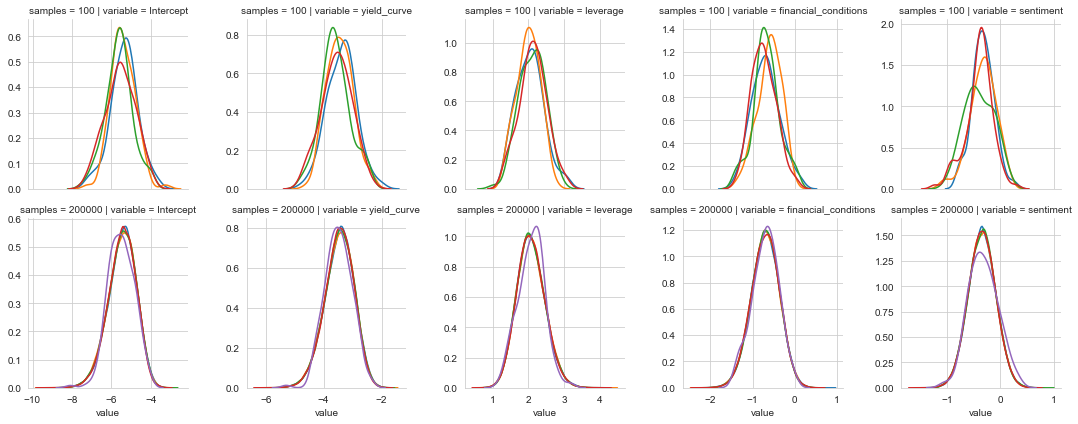

In [97]:
g = sns.FacetGrid(trace_df_long, col='variable', row='samples',
                  hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False)
g.savefig('figures/logistic_regression_comp', dpi=300)

In [55]:
model = smf.logit(formula=full_model, data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.169693
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              recession   No. Observations:                  445
Model:                          Logit   Df Residuals:                      440
Method:                           MLE   Df Model:                            4
Date:                Sun, 19 Apr 2020   Pseudo R-squ.:                  0.5039
Time:                        21:04:05   Log-Likelihood:                -75.513
converged:                       True   LL-Null:                       -152.20
Covariance Type:            nonrobust   LLR p-value:                 3.842e-32
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.2196      0.674     -7.740      0.000      -6.541      -3.898

In [56]:
pm.summary(trace_NUTS).assign(statsmodels=result.params).to_csv(model_path / 'trace_nuts.csv')

In [57]:
pm.summary(trace_NUTS).assign(statsmodels=result.params)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,statsmodels
Intercept,-5.465,0.713,-6.816,-4.172,0.003,0.002,68142.0,66632.0,69617.0,78945.0,1.0,-5.219610
yield_curve,-3.465,0.507,-4.438,-2.546,0.002,0.001,70479.0,68704.0,71788.0,80095.0,1.0,-3.304562
leverage,2.075,0.398,1.341,2.829,0.001,0.001,72639.0,70697.0,73513.0,87656.0,1.0,1.977609
financial_conditions,-0.700,0.334,-1.325,-0.071,0.001,0.001,91104.0,87831.0,91568.0,107232.0,1.0,-0.654439
sentiment,-0.340,0.256,-0.818,0.145,0.001,0.001,106751.0,100261.0,106791.0,114138.0,1.0,-0.327591


### Computing Credible Intervals

We can compute the credible intervals, the Bayesian counterpart of confidence intervals, as percentiles of the trace. The resulting boundaries reflect our confidence about the range of the parameter value for a given probability threshold, as opposed to the number of times the parameter will be within this range for a large number of trials.

In [58]:
def get_credible_int(trace, param):
    b = trace[param]
    lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
    lb, ub = np.exp(lb), np.exp(ub)
    return b, lb, ub

In [59]:
b = trace_NUTS['yield_curve']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.011 < Odds Ratio < 0.078) = 0.95


In [60]:
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.011 < Odds Ratio < 0.078) = 0.95


''

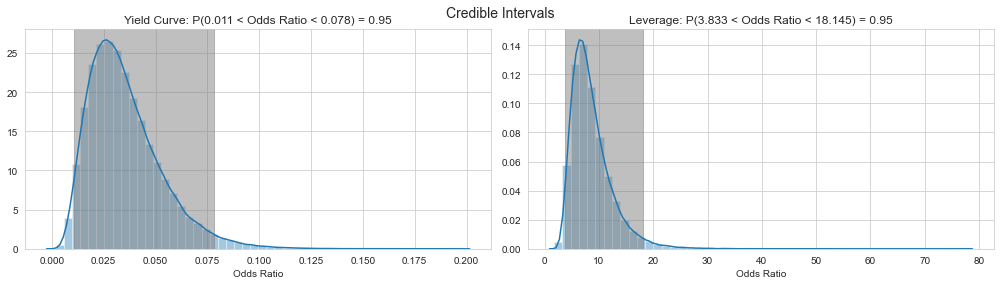

In [61]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[0])
axes[0].set_title(f'Yield Curve: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[0].axvspan(lb, ub, alpha=0.5, color='gray')

b, lb, ub = get_credible_int(trace_NUTS, 'leverage')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[1])
axes[1].set_title(f'Leverage: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[1].axvspan(lb, ub, alpha=0.5, color='gray')

fig.suptitle('Credible Intervals', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
# fig.savefig('figures/workflow_credible_int')
;

## Variational Inference

### Run Automatic Differentation Variational Inference (ADVI)

The interface for variational inference is very similar to the MCMC implementation. We just use the fit() instead of the sample() function, with the option to include an early stopping CheckParametersConvergence callback if the distribution-fitting process converged up to a given tolerance:

In [62]:
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=100000, 
                    callbacks=[callback])

Average Loss = 110.83: 100%|██████████| 100000/100000 [00:22<00:00, 4514.63it/s]
Finished [100%]: Average Loss = 110.83


### Persist Result

In [63]:
with open(model_path / 'logistic_model_advi.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model,
                 'approx': approx}, buff)

### Sample from approximated distribution

We can draw samples from the approximated distribution to obtain a trace object as above for the MCMC sampler:

In [64]:
trace_advi = approx.sample(10000)

In [65]:
pm.summary(trace_advi)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-5.397,0.230,-5.827,-4.967,0.002,0.002,9914.0,9914.0,9930.0,9385.0,NaN
yield_curve,-3.418,0.185,-3.770,-3.075,0.002,0.001,9851.0,9841.0,9852.0,9719.0,NaN
leverage,2.028,0.189,1.667,2.376,0.002,0.001,9860.0,9860.0,9864.0,9020.0,NaN
financial_conditions,-0.693,0.215,-1.107,-0.297,0.002,0.002,9929.0,9929.0,9925.0,9427.0,NaN
sentiment,-0.328,0.206,-0.715,0.059,0.002,0.001,10162.0,10162.0,10168.0,9879.0,NaN


In [66]:
pm.summary(trace_advi).to_csv(model_path / 'trace_advi.csv')

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


## Model Diagnostics

Bayesian model diagnostics includes validating that the sampling process has converged and consistently samples from high-probability areas of the posterior, and confirming that the model represents the data well.

For high-dimensional models with many variables, it becomes cumbersome to inspect numerous at traces. When using NUTS, the energy plot helps to assess problems of convergence. It summarizes how efficiently the random process explores the posterior. The plot shows the energy and the energy transition matrix that should be well matched as in the below example (see references for conceptual detail).

### Energy Plot

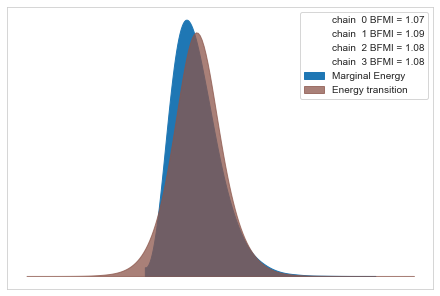

In [67]:
pm.energyplot(trace_NUTS);

### Forest Plot

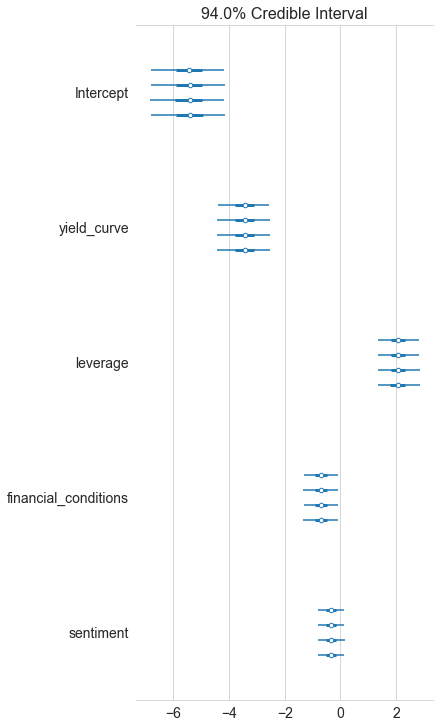

In [68]:
pm.forestplot(trace_NUTS);

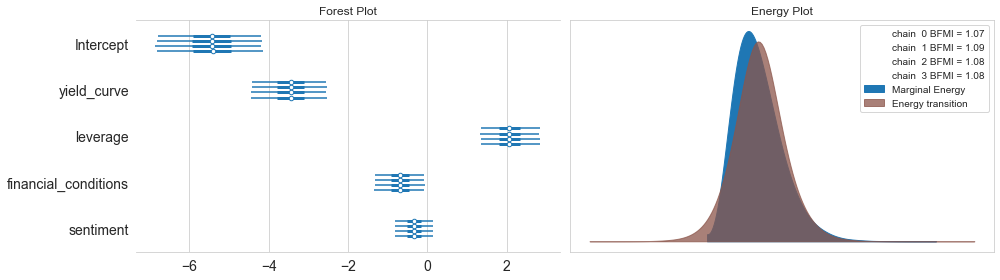

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
pm.forestplot(trace_NUTS, ax=axes[0])
axes[0].set_title('Forest Plot')

pm.energyplot(trace_NUTS, ax=axes[1])
axes[1].set_title('Energy Plot')

fig.tight_layout()
fig.savefig('figures/workflow_energy_forest', dpi=300);

### Posterior Predictive Checks

PPCs are very useful for examining how well a model fits the data. They do so by generating data from the model using parameters from draws from the posterior. We use the function pm.sample_ppc for this purpose and obtain n samples for each observation (the GLM module automatically names the outcome ‘y’):

In [70]:
ppc = pm.sample_ppc(trace_NUTS, samples=500, model=logistic_model)

100%|██████████| 500/500 [00:00<00:00, 1580.56it/s]


In [71]:
ppc['y'].shape

(500, 445)

In [72]:
y_score = np.mean(ppc['y'], axis=0)

In [73]:
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=data.recession)

0.9483627204030226

## Prediction
Follows PyMC3 [docs](https://docs.pymc.io/notebooks/posterior_predictive.html)

Predictions use theano’s shared variables to replace the training data with test data before running posterior predictive checks. To facilitate visualization, we create a variable with a single predictor hours, create the train and test datasets, and convert the former to a shared variable. Note that we need to use numpy arrays and provide a list of column labels:

### Train-test split

In [111]:
X = data[['yield_curve']]
labels = X.columns
y = data.recession
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

### Create shared theano variable

In [112]:
X_shared = theano.shared(X_train.values)

### Define logistic model

In [113]:
with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=X_shared, 
               labels=labels,
               y=y_train, 
               family=pm.glm.families.Binomial())

### Run NUTS sampler

In [114]:
with logistic_model_pred:
    pred_trace = pm.sample(draws=10000, 
                           tune=1000,
                           chains=2,
                           cores=2,
                           init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [yield_curve, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 22000/22000 [00:08<00:00, 2621.24draws/s]
The number of effective samples is smaller than 25% for some parameters.


### Replace shared variable with test set

We then run the sampler as before, and apply the pm.sample_ppc function to the resulting trace after replacing the train with test data:

In [115]:
X_shared.set_value(X_test)

In [116]:
ppc = pm.sample_ppc(pred_trace,
                    model=logistic_model_pred,
                    samples=100)

100%|██████████| 100/100 [00:00<00:00, 607.28it/s]


#### Check AUC Score

In [117]:
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=y_test)

0.8386075949367089

In [119]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

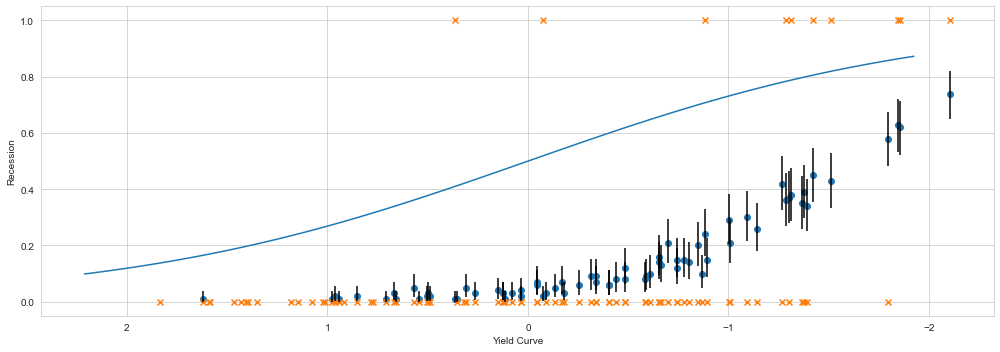

In [121]:
x = X_test.yield_curve

fig, ax = plt.subplots(figsize=(14, 5))

β = stats.beta((ppc['y'] == 1).sum(axis=0), (ppc['y'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=x, y=β.mean())

# error bars on the estimate
plt.vlines(x, *β.interval(0.95))

# actual outcomes
ax.scatter(x=x, y=y_test, marker='x')

# True probabilities
x_ = np.linspace(x.min()*1.05, x.max()*1.05, num=100)
ax.plot(-x_, invlogit(x_), linestyle='-')

ax.set_xlabel('Yield Curve')
ax.set_ylabel('Recession')
ax.invert_xaxis()
fig.tight_layout()
# fig.savefig(fig_path / 'workflow_predictions', dpi=300)
;

## MCMC Sampler Animation
The code is based on [MCMC visualization tutorial](https://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/).

### Setup

In [85]:
# Number of MCMC iteration to animate.
burnin = 1000
samples = 1000

var1 = 'yield_curve'
var1_range = (trace_df[var1].min() * .95, trace_df[var1].max() * 1.05)

var2 = 'sentiment'
var2_range = (trace_df[var2].min() * .95, trace_df[var2].max() * 1.05)

In [86]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [87]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

### NUTS samples

In [88]:
def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

In [89]:
with logistic_model:
    nuts_trace = pm.sample(draws=samples, tune=burnin,
                      init='adapt_diag',
                      chains=1)
    trace_df = pm.trace_to_dataframe(nuts_trace)
trace_df.to_csv('trace.csv', index=False)
trace_df = pd.read_csv('trace.csv')
print(trace_df.info())

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]
Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 595.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             1000 non-null   float64
 1   yield_curve           1000 non-null   float64
 2   leverage              1000 non-null   float64
 3   financial_conditions  1000 non-null   float64
 4   sentiment             1000 non-null   float64
dtypes: float64(5)
memory usage: 39.2 KB
None


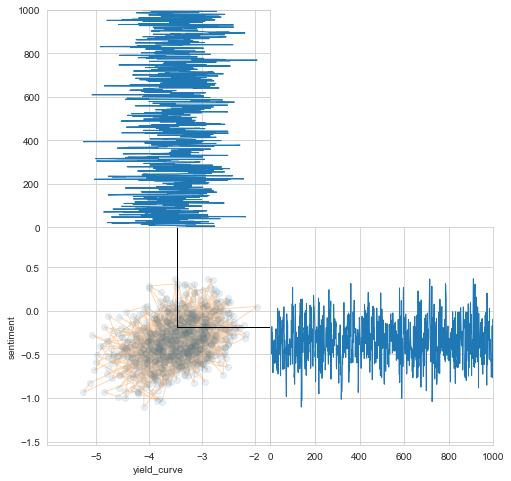

In [90]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]


anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

# save
anim.save(fig_path / 'nuts.mp4', writer=writer)

# or display
HTML(anim.to_html5_video())

### Metropolis-Hastings samples

In [91]:
with logistic_model:
    step = pm.Metropolis()
    mh_trace = pm.sample(draws=samples, tune=burnin,
                      step=step,
                      chains=1)
    trace_df = pm.trace_to_dataframe(mh_trace)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]
Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1376.90it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [93]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

In [94]:
anim.save(fig_path / 'metropolis_hastings.mp4', writer=writer)

# HTML(anim.to_html5_video())